<a href="https://colab.research.google.com/github/Adachika/Capstone/blob/main/capstone_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Exploration

In [ ]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/data2.csv', skipinitialspace = True)

In [ ]:
df.head()

,Year,Month,time index,FFR,GDP,MS,UI,Gas Price,S&P 500
0,1991,Jan,1,1.545946,-1.589107,-1.150451,0.383277,1.000,343.9
1,1991,Feb,2,1.488320,-1.589107,-1.145532,0.509800,1.094,367.1
2,1991,Mar,3,1.395232,-1.566827,-1.141280,0.446539,1.040,375.2
3,1991,Apr,4,1.337606,-1.566827,-1.137917,0.573061,1.076,375.4
4,1991,May,5,1.390799,-1.566827,-1.135981,0.573061,1.126,389.8


In [ ]:
# Drop time index column
df= df.drop(['time index'],axis =1)


In [ ]:
df

,Year,Month,FFR,GDP,MS,UI,Gas Price,S&P 500
0,1991,Jan,1.545946,-1.589107,-1.150451,0.383277,1.000,343.9
1,1991,Feb,1.488320,-1.589107,-1.145532,0.509800,1.094,367.1
2,1991,Mar,1.395232,-1.566827,-1.141280,0.446539,1.040,375.2
3,1991,Apr,1.337606,-1.566827,-1.137917,0.573061,1.076,375.4
4,1991,May,1.390799,-1.566827,-1.135981,0.573061,1.126,389.8
...,...,...,...,...,...,...,...,...
319,2017,Aug,-0.714772,1.818101,2.148792,-1.134993,2.380,2476.4
320,2017,Sep,-0.714772,1.815304,2.165853,-1.198254,2.645,2476.6
321,2017,Oct,-0.710340,1.855704,2.174257,-1.198254,2.505,2529.1
322,2017,Nov,-0.648281,1.869676,2.191773,-1.198254,2.564,2579.4


In [ ]:
df.shape

(324, 8)

Timeseries plot

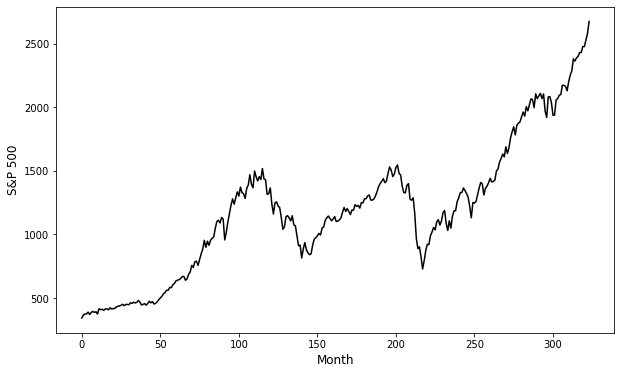

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})
    #plt.savefig('drive/My Drive/Colab Notebooks/LSTM&GRU/1.jpg', format='jpg', dpi=1000)

timeseries(df.index, df['S&P 500'], 'Month', 
           'S&P 500')

In [ ]:
# Set Month as index
df = df.set_index(['Month'])

In [ ]:
df

,Year,FFR,GDP,MS,UI,Gas Price,S&P 500
Month,,,,,,,
Jan,1991,1.545946,-1.589107,-1.150451,0.383277,1.000,343.9
Feb,1991,1.488320,-1.589107,-1.145532,0.509800,1.094,367.1
Mar,1991,1.395232,-1.566827,-1.141280,0.446539,1.040,375.2
Apr,1991,1.337606,-1.566827,-1.137917,0.573061,1.076,375.4
May,1991,1.390799,-1.566827,-1.135981,0.573061,1.126,389.8
...,...,...,...,...,...,...,...
Aug,2017,-0.714772,1.818101,2.148792,-1.134993,2.380,2476.4
Sep,2017,-0.714772,1.815304,2.165853,-1.198254,2.645,2476.6
Oct,2017,-0.710340,1.855704,2.174257,-1.198254,2.505,2529.1


In [ ]:
# Remove whitespaces
df.columns = df.columns.str.strip()

In [ ]:
# Drop GDP column
df= df.drop(['GDP'],axis =1)
df

,Year,FFR,MS,UI,Gas Price,S&P 500
Month,,,,,,
Jan,1991,1.545946,-1.150451,0.383277,1.000,343.9
Feb,1991,1.488320,-1.145532,0.509800,1.094,367.1
Mar,1991,1.395232,-1.141280,0.446539,1.040,375.2
Apr,1991,1.337606,-1.137917,0.573061,1.076,375.4
May,1991,1.390799,-1.135981,0.573061,1.126,389.8
...,...,...,...,...,...,...
Aug,2017,-0.714772,2.148792,-1.134993,2.380,2476.4
Sep,2017,-0.714772,2.165853,-1.198254,2.645,2476.6
Oct,2017,-0.710340,2.174257,-1.198254,2.505,2529.1


Split the dataset into train and test data

Rename column

In [ ]:
df = df.rename(columns = {'FFR':'FFR', 'MS':'MS',
                          'UI':'UI','Gas Price':'GP','S&P 500':'SP'})
df


,Year,FFR,MS,UI,GP,SP
Month,,,,,,
Jan,1991,1.545946,-1.150451,0.383277,1.000,343.9
Feb,1991,1.488320,-1.145532,0.509800,1.094,367.1
Mar,1991,1.395232,-1.141280,0.446539,1.040,375.2
Apr,1991,1.337606,-1.137917,0.573061,1.076,375.4
May,1991,1.390799,-1.135981,0.573061,1.126,389.8
...,...,...,...,...,...,...
Aug,2017,-0.714772,2.148792,-1.134993,2.380,2476.4
Sep,2017,-0.714772,2.165853,-1.198254,2.645,2476.6
Oct,2017,-0.710340,2.174257,-1.198254,2.505,2529.1


Dimension of train data:  (259, 6)
Dimension of test data:  (65, 6)


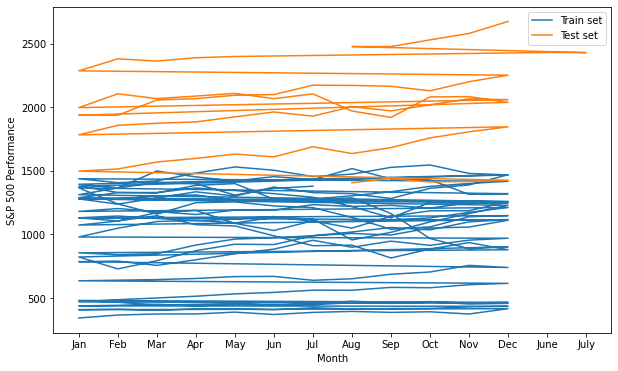

In [ ]:
# 80% of data as train data and the remaining 20% as test data. 
# model is trained with train data and the performance is validated with test data.

train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.SP)
plt.plot(test_dataset.SP)
plt.xlabel('Month')
plt.ylabel('S&P 500 Performance')
plt.legend(['Train set', 'Test set'], loc='upper right')
 #plt.savefig('drive/My Drive/Colab Notebooks/LSTM&GRU/2.jpg', format='jpg', dpi=1000)
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

Split the target variable and dependent variables

In [ ]:
# SP is the target variable(output) and is a function of the input variables
# Split train data to X and y
X_train = train_dataset.drop('SP', axis = 1)
y_train = train_dataset.loc[:,['SP']]

# Split test data to X and y
X_test = test_dataset.drop('SP', axis = 1)
y_test = test_dataset.loc[:,['SP']]

Data Transformation

In [ ]:
# A good rule of thumb is that normalized data lead to better performance in Neural Networks

# Transform X_train, y_train, X_test and y_test

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

Create a 3D Input Dataset

In [ ]:
# LSTM, GRU and BiLSTM take a 3D input (num_samples, num_timesteps, num_features). 

def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (35, 30, 5)
y_train.shape:  (229, 1)
X_test.shape:  (35, 30, 5)
y_test.shape:  (229, 1)


Create BiLSTM, LSTM and GRU model

In [ ]:
# The first function, create_model_bilstm, creates a BDLSM and gets the number of units (neurons) in hidden layers. 
# The second function, create_model, gets two inputs; number of units in hidden layers and model name (LSTM or GRU).

# For the sake of simplicity, BiLSTM, LSTM and GRU have 2 hidden layers including 64 neurons and 1 neuron in the output layer.

# To make the LSTM and GRU networks robust to changes, the Dropout function is used. Dropout(0.2) randomly drops 20% of units from the network.

# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)


Fit the models

In [ ]:
#Train the model with train data for 100 epoch and batch_size = 32.
# Model uses 20% of train data as validation data. 
#It is important to set shuffle = False because the order of the data matters in our project.

# To avoid overfitting,  early stop is used to stop training when "val_loss" has not improved after 10 epochs (patience = 10).

# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)


Epoch 1/100
6/6 [==============================] - 7s 358ms/step - loss: 0.0745 - val_loss: 0.1134
Epoch 2/100
6/6 [==============================] - 0s 61ms/step - loss: 0.1667 - val_loss: 0.0707
Epoch 3/100
6/6 [==============================] - 0s 66ms/step - loss: 0.0599 - val_loss: 0.0268
Epoch 4/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0249 - val_loss: 0.0887
Epoch 5/100
6/6 [==============================] - 0s 63ms/step - loss: 0.0264 - val_loss: 0.0867
Epoch 6/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0177 - val_loss: 0.0388
Epoch 7/100
6/6 [==============================] - 0s 58ms/step - loss: 0.0182 - val_loss: 0.0413
Epoch 8/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0136 - val_loss: 0.0477
Epoch 9/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0117 - val_loss: 0.0475
Epoch 10/100
6/6 [==============================] - 0s 57ms/step - loss: 0.0113 - val_loss: 0.0531
Epoch 11/100
6/6 [

Plot train loss versus validation loss

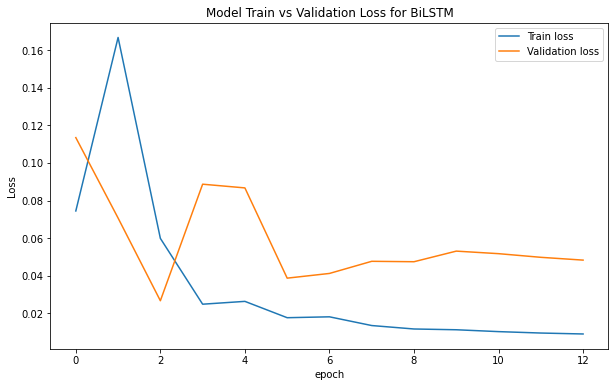

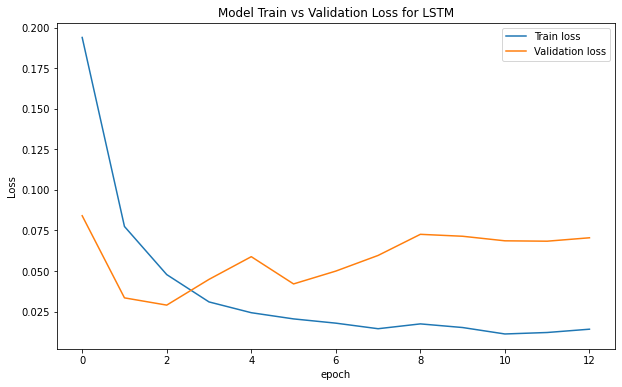

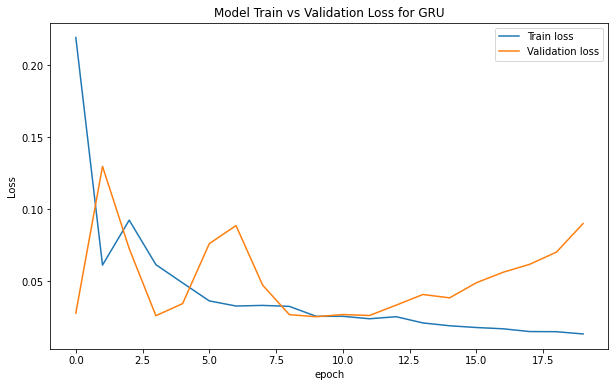

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

Inverse target variable for train and test data

In [ ]:
# After building the model, I have to transform the target variable back to original data space for train and test data using scaler_y.inverse_transform.
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [ ]:
# Print y_test
pd.set_option('display.max_rows', None)
print(y_test)

[[2105.2]
 [2067.6]
 [2087.4]
 [2108.6]
 [2067. ]
 [2104.5]
 [1970.1]
 [1919.7]
 [2080.8]
 [2082.9]
 [2038.2]
 [1936.9]
 [1937.1]
 [2056.6]
 [2067.2]
 [2093.9]
 [2099.3]
 [2173.1]
 [2171.3]
 [2164.3]
 [2128.7]
 [2200.2]
 [2251.6]
 [2285.6]
 [2380.1]
 [2362.3]
 [2388.5]
 [2398.4]
 [2430.1]
 [2429. ]
 [2476.4]
 [2476.6]
 [2529.1]
 [2579.4]
 [2673.6]]


Make predictions

In [ ]:
# Let's predict S&P value using BiLSTM, LSTM and GRU models.
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

In [ ]:
# Print GRU predictions
prediction_gru

array([[1631.6652],
       [1677.8578],
       [1717.8558],
       [1748.6324],
       [1771.6617],
       [1788.833 ],
       [1802.957 ],
       [1817.6737],
       [1834.0641],
       [1851.5972],
       [1871.1302],
       [1893.9609],
       [1922.3613],
       [1951.1173],
       [1975.2338],
       [1997.247 ],
       [2011.4716],
       [2019.2408],
       [2024.8947],
       [2030.0269],
       [2035.6571],
       [2043.9756],
       [2053.354 ],
       [2061.393 ],
       [2072.5754],
       [2088.775 ],
       [2107.452 ],
       [2125.4082],
       [2142.2446],
       [2158.1218],
       [2170.8064],
       [2182.302 ],
       [2190.3518],
       [2197.3552],
       [2204.0989]], dtype=float32)

Plot true future versus prediction

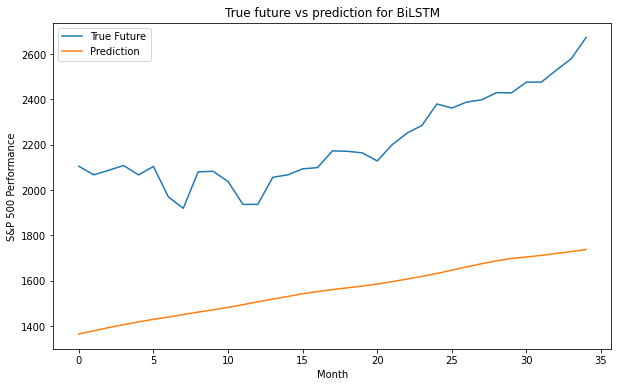

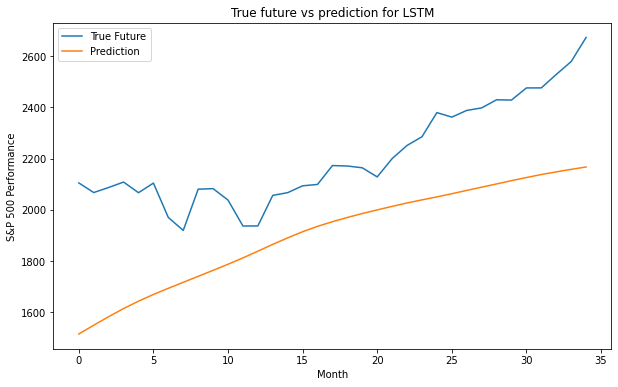

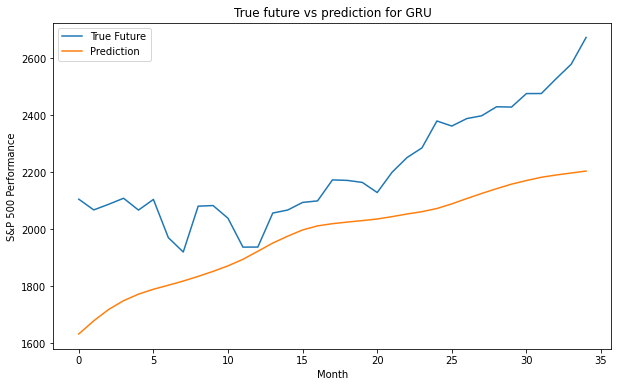

In [ ]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Month')
    plt.ylabel('S&P 500 Performance')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

Calculate RMSE and MAE

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')


Bidirectional LSTM:
Mean Absolute Error: 650.1929
Root Mean Square Error: 659.9526

LSTM:
Mean Absolute Error: 301.9627
Root Mean Square Error: 326.6137

GRU:
Mean Absolute Error: 232.7985
Root Mean Square Error: 260.4681



In [ ]:
# Coefficient of determination (R-squared)
from sklearn.metrics import r2_score
score = r2_score(y_test, prediction_gru)
print(score)

-0.7703520468283538
